# Generating the input waveform for our FIR testbench (fir_tb.vhdl)

We'll generate a "chirp" signal, a.k.a. a "frequency sweep". The time domain signal will look like this:

![image.png](chirp.png)

while the frequency domain is a linear ramp (for a linear chirp. There are other methods, you can do log chirps that go up faster etc.)

This signal will be saved to a text file, which the testbench will read in VHDL and apply to the DUT.

In [1]:
import numpy as np
from scipy.signal import chirp
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

clk_prd_ns  = 10; # same as clock_period in fir_tb.vhdl
t_stop_ns   = 1e6; # we chose this arbitrarily, just make sure your simulation length is >= this

num_pts     = int(t_stop_ns/clk_prd_ns);

t = np.linspace(0, t_stop_ns/1e9, num_pts) # 0=t_start. Every tick in t corresponds to one clock cycle in the testbench

chirp_start_freq_hz = 1e6; # our example LPF has a cutoff at 3 MHz, we're sweeping from 1 to 5 to see the drop in power
chirp_stop_freq_hz  = 5e6;

x = chirp(t, f0=chirp_start_freq_hz, f1=chirp_stop_freq_hz, t1=t_stop_ns/1e9, method='linear');

### demonstrate the chirp

plot two parts together (one near the start and one near the end)

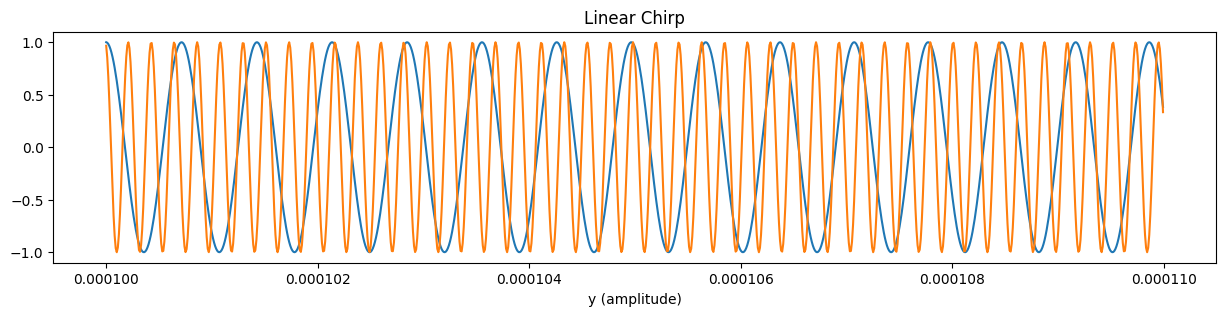

In [2]:
figure(figsize=(15, 3))
plt.plot(t[10000:11000], x[10000:11000])
plt.plot(t[10000:11000], x[90000:91000])
plt.title("Linear Chirp")
plt.xlabel('t (sec) - not aligned for the two plots')
plt.xlabel('y (amplitude)')
plt.show()

### generate the testbench input text file

In [3]:
Data_Width = 16; 

Text_file_input = 'Filter_input.txt';

# FIIIR output, Rect window, Sampling rate [Hz]: 100000000, Cutoff frequency fL [Hz]: 30000000, Transition bandwidth bL [Hz]: 60000000
Coeff = np.asarray([
    0.044837646966218309,
    0.049731264531794481,
    0.054200707306836522,
    0.058153822698646433,
    0.061508335584787771,
    0.064193905791532613,
    0.066153894530927473,
    0.067346791360523753,
    0.067747262457465304,
    0.067346791360523753,
    0.066153894530927473,
    0.064193905791532613,
    0.061508335584787771,
    0.058153822698646433,
    0.054200707306836522,
    0.049731264531794481,
    0.044837646966218309,
]);

Max = (2**(Data_Width-1)-1);

Coeff_int = np.round(Coeff*Max).astype(int);
x_int     = np.round(x*Max).astype(int);  

In [4]:
with open(Text_file_input, "w") as txt_file:
    for line in x_int:
        txt_file.write(str(line) + "\n")

### Find hex versions of coefficients

In [5]:
vhex = np.vectorize(hex)
vhex(Coeff_int.astype(np.int16))

array(['0x5bd', '0x65e', '0x6f0', '0x772', '0x7df', '0x837', '0x878',
       '0x89f', '0x8ac', '0x89f', '0x878', '0x837', '0x7df', '0x772',
       '0x6f0', '0x65e', '0x5bd'], dtype='<U5')

VHDL version of the hex array:

    x"05bd", x"065e", x"06f0", x"0772", x"07df", x"0837", x"0878",
    x"089f", x"08ac", x"089f", x"0878", x"0837", x"07df", x"0772",
    x"06f0", x"065e", x"05bd"

### generate reference signal in python (should match the DUT output from the testbench)

In [6]:
y_ref = (np.convolve(x_int, Coeff_int)/(2**(Data_Width-1))).astype(int);

y_ref needs to be shifted by the number of clock cycles the circuit takes to run to match the real case

it's 5 in this case

In [7]:
y_ref = np.concatenate((np.zeros(5,dtype=int),y_ref));

### compare the output with the reference

plot it against the input to see the ramp down

In [8]:
with open(Text_file_input) as f:
    inp_list = []
    for line in f:
        inp_list.append(int(line))

Text_file_output = "Filter_output.txt"; 
with open(Text_file_output) as f:
    out_list = []
    for line in f:
        out_list.append(int(line))

In [9]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

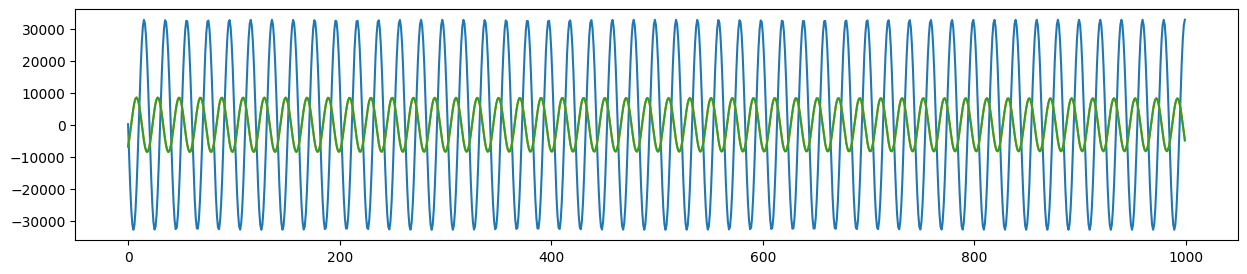

In [10]:
s_smpls = 99000
e_smpls = 100000
figure(figsize=(15, 3))
plt.plot(inp_list[s_smpls:e_smpls])
plt.plot(out_list[s_smpls:e_smpls])
plt.plot(y_ref[s_smpls:e_smpls])

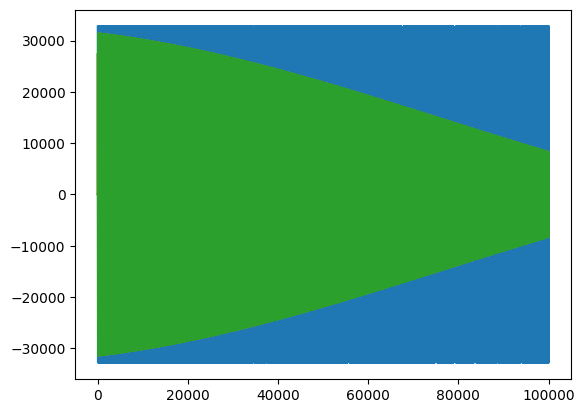

In [11]:
plt.plot(inp_list)
plt.plot(out_list)
plt.plot(y_ref)